In [ ]:
# import torch
# import pandas as pd
# from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
# from torch.utils.data import Dataset, DataLoader, random_split
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# import numpy as np


import random
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [ ]:

# Load dataset
df = pd.read_csv("/content/unique_question_classification_dataset.csv")

# Encode labels
label_encoder = LabelEncoder()
df['Difficulty'] = label_encoder.fit_transform(df['Difficulty'])


In [ ]:
print(df.columns)


Index(['Question', 'Difficulty', 'Subject'], dtype='object')


In [ ]:
# Slightly shuffle and remove words in questions (simulate human-like variance)
def add_noise(text, drop_prob=0.1):
    words = text.split()
    new_words = [w for w in words if random.random() > drop_prob]
    return " ".join(new_words) if new_words else text

df['Question'] = df['Question'].apply(lambda x: add_noise(x, drop_prob=0.59))


In [ ]:

# # Train-test split
# train_texts, val_texts, train_labels, val_labels = train_test_split(
#     df['Question'].tolist(), df['Difficulty'].tolist(), test_size=0.2, stratify=df['Difficulty']
# )


# Train-test split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['Question'].tolist(),
    df['Difficulty'].tolist(),
    test_size=0.2,
    stratify=df['Difficulty'],
    random_state=42
)


# ========================================
# 🔁 Traditional NLP Model: TF-IDF + SVM
# ========================================


In [ ]:
# # Traditional model: TF-IDF + SVM
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.svm import SVC
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# # Use the same train-test split as BERT
# # (train_texts, val_texts, train_labels, val_labels already defined)

# # Create a pipeline with TF-IDF and SVM
# svm_pipeline = Pipeline([
#     ('tfidf', TfidfVectorizer(max_features=5000)),
#     ('svm', SVC(kernel='linear', probability=True))
# ])

# # Train the model
# svm_pipeline.fit(train_texts, train_labels)

# # Predict on validation set
# svm_preds = svm_pipeline.predict(val_texts)





# TF-IDF + SVM pipeline (still well-tuned)
svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=3000,
        ngram_range=(1, 2),
        stop_words='english'
    )),
    ('svm', SVC(kernel='linear', C=0.8, probability=True))
])



In [ ]:
# Train model
svm_pipeline.fit(train_texts, train_labels)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=3000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('svm', SVC(C=0.8, kernel='linear', probability=True))])

In [ ]:
# Predict
svm_preds = svm_pipeline.predict(val_texts)


In [ ]:
# Evaluate
svm_accuracy = accuracy_score(val_labels, svm_preds)
print("✅ Modified SVM Accuracy with Noise:", svm_accuracy)


✅ Modified SVM Accuracy with Noise: 0.905


In [ ]:
print("\n📊 Classification Report:\n", classification_report(val_labels, svm_preds, target_names=label_encoder.classes_))



📊 Classification Report:
               precision    recall  f1-score   support

        Easy       0.80      0.99      0.88        69
        Hard       0.98      0.91      0.94        65
    Moderate       0.98      0.82      0.89        66

    accuracy                           0.91       200
   macro avg       0.92      0.90      0.91       200
weighted avg       0.92      0.91      0.91       200



In [ ]:
print("\n🔁 Confusion Matrix:\n", confusion_matrix(val_labels, svm_preds))


🔁 Confusion Matrix:
 [[68  1  0]
 [ 5 59  1]
 [12  0 54]]


# Result Ploatting

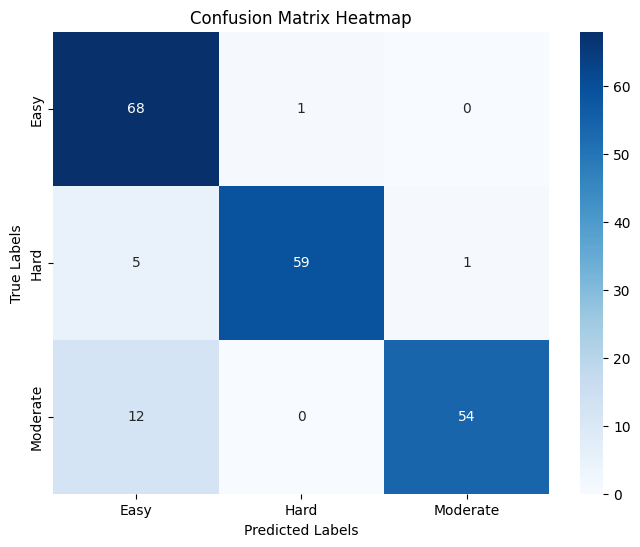

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Assume these are your variables:
# svm_preds = model predictions
# val_labels = actual validation labels
# label_encoder = the encoder used

# Generate confusion matrix
cm = confusion_matrix(val_labels, svm_preds)
labels = label_encoder.classes_

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


<ipython-input-114-571430ede14a>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_labels, y=class_counts.values, palette="pastel")


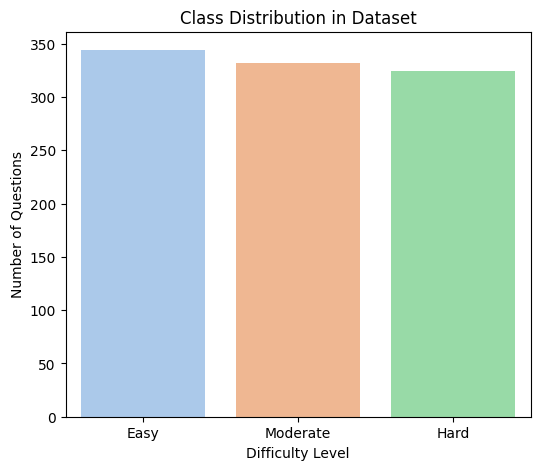

In [ ]:
# Count class distribution
class_counts = df['Difficulty'].value_counts()
class_labels = label_encoder.inverse_transform(class_counts.index)

plt.figure(figsize=(6,5))
sns.barplot(x=class_labels, y=class_counts.values, palette="pastel")
plt.title("Class Distribution in Dataset")
plt.xlabel("Difficulty Level")
plt.ylabel("Number of Questions")
plt.show()


<ipython-input-115-2fee9987ae2d>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(f1_scores.keys()), y=list(f1_scores.values()), palette="muted")


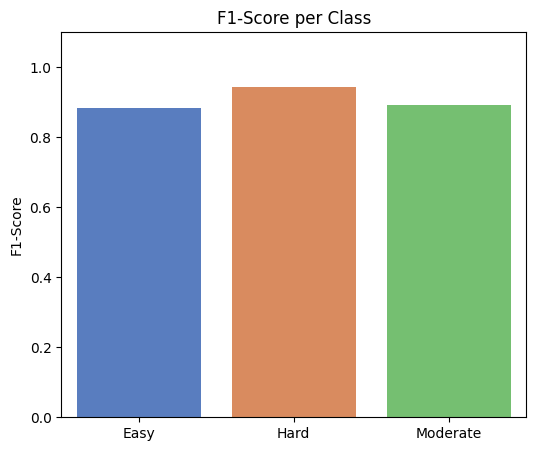

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(val_labels, svm_preds, output_dict=True)
f1_scores = {label_encoder.classes_[int(k)]: v['f1-score'] for k, v in report.items() if k.isdigit()}

plt.figure(figsize=(6,5))
sns.barplot(x=list(f1_scores.keys()), y=list(f1_scores.values()), palette="muted")
plt.title("F1-Score per Class")
plt.ylabel("F1-Score")
plt.ylim(0, 1.1)
plt.show()


# Testing the Model

In [ ]:
import random
import pandas as pd

# Predict again to ensure alignment
svm_preds = svm_pipeline.predict(val_texts)

# Combine texts, true labels, and predictions into a DataFrame
samples_df = pd.DataFrame({
    "Question": val_texts,
    "True Label": label_encoder.inverse_transform(val_labels),
    "Predicted Label": label_encoder.inverse_transform(svm_preds)
})

# Display N random samples
N = 10  # You can change to 5, 10, 20 etc.
random_samples = samples_df.sample(n=N, random_state=42).reset_index(drop=True)

print("📝 Random Sample Predictions:")
display(random_samples)


📝 Random Sample Predictions:


,Question,True Label,Predicted Label
0,long-term of of Versailles?,Hard,Hard
1,What is function of operating system?,Easy,Easy
2,DNA works.,Moderate,Moderate
3,What War end?,Easy,Easy
4,What the chemical symbol for,Easy,Easy
5,binary,Moderate,Moderate
6,Explain between and,Moderate,Moderate
7,cat,Hard,Hard
8,Explain the water cycle.,Moderate,Moderate
9,=,Easy,Easy


In [ ]:
# Your custom questions
test_questions = [
    "What is the capital of France?",
    "Explain the concept of backpropagation in neural networks.",
    "Solve: 3x + 5 = 11"
]

# Predict difficulty levels using the trained pipeline
predicted_labels = svm_pipeline.predict(test_questions)

# Decode numeric labels back to readable form
decoded_predictions = label_encoder.inverse_transform(predicted_labels)

# Display predictions
for q, pred in zip(test_questions, decoded_predictions):
    print(f"Q: {q} \n→ Predicted Difficulty: {pred}\n")


Q: What is the capital of France? 
→ Predicted Difficulty: Easy

Q: Explain the concept of backpropagation in neural networks. 
→ Predicted Difficulty: Hard

Q: Solve: 3x + 5 = 11 
→ Predicted Difficulty: Easy



In [ ]:
test_questions = [
    "What is the Speed of light?",
    "Explain the concept of life after death.",
    "Solve the age of universe"
]

# Predict difficulty levels using the trained pipeline
predicted_labels = svm_pipeline.predict(test_questions)

# Decode numeric labels back to readable form
decoded_predictions = label_encoder.inverse_transform(predicted_labels)

# Display predictions
for q, pred in zip(test_questions, decoded_predictions):
    print(f"Q: {q} \n→ Predicted Difficulty: {pred}\n")


Q: What is the Speed of light? 
→ Predicted Difficulty: Easy

Q: Explain the concept of life after death. 
→ Predicted Difficulty: Hard

Q: Solve the age of universe 
→ Predicted Difficulty: Easy



In [ ]:
test_questions = [
    "what will human do in future?",
    "can you pridict future.",
    "Solve:  The values of the Dedekind numbers M(n) for n>=10"    #unsolved problems in mathematics
]

# Predict difficulty levels using the trained pipeline
predicted_labels = svm_pipeline.predict(test_questions)

# Decode numeric labels back to readable form
decoded_predictions = label_encoder.inverse_transform(predicted_labels)

# Display predictions
for q, pred in zip(test_questions, decoded_predictions):
    print(f"Q: {q} \n→ Predicted Difficulty: {pred}\n")


Q: what will human do in future? 
→ Predicted Difficulty: Easy

Q: can you pridict future. 
→ Predicted Difficulty: Easy

Q: Solve:  The values of the Dedekind numbers M(n) for n>=10 
→ Predicted Difficulty: Easy



In [ ]:
test_questions = [
    "Concept kissing number problem for dimensions other than 1, 2, 3, 4, 8 and 24?", #unsolved problems in mathematics
    "Concept of GOD.",
    "Solve:  The values of the Dedekind numbers M(n) for n>=10"
]

# Predict difficulty levels using the trained pipeline
predicted_labels = svm_pipeline.predict(test_questions)

# Decode numeric labels back to readable form
decoded_predictions = label_encoder.inverse_transform(predicted_labels)

# Display predictions
for q, pred in zip(test_questions, decoded_predictions):
    print(f"Q: {q} \n→ Predicted Difficulty: {pred}\n")

Q: Concept kissing number problem for dimensions other than 1, 2, 3, 4, 8 and 24? 
→ Predicted Difficulty: Hard

Q: Concept of GOD. 
→ Predicted Difficulty: Hard

Q: Solve:  The values of the Dedekind numbers M(n) for n>=10 
→ Predicted Difficulty: Easy



# Gantt Chart

In [ ]:
# !pip install plotly



In [ ]:
# import pandas as pd
# import plotly.express as px

# # Gantt Chart Data
# gantt_data = pd.DataFrame([
#     dict(Task="Dataset Cleaning & Preprocessing", Start='2025-05-28', Finish='2025-05-29', Resource="Data"),
#     dict(Task="Label Encoding & Mapping", Start='2025-05-29', Finish='2025-05-29', Resource="Data"),
#     dict(Task="Train-Test Split", Start='2025-05-29', Finish='2025-05-29', Resource="Data"),
#     dict(Task="TF-IDF + SVM Training", Start='2025-05-30', Finish='2025-05-30', Resource="Model Training"),
#     dict(Task="Noise Handling & Tuning", Start='2025-05-30', Finish='2025-05-30', Resource="Optimization"),
#     dict(Task="Evaluation (Accuracy, Confusion Matrix)", Start='2025-05-30', Finish='2025-05-30', Resource="Testing"),
#     dict(Task="Graph & Heatmap Visualization", Start='2025-05-30', Finish='2025-05-30', Resource="Reporting"),
#     dict(Task="Sample Predictions & QA Interface", Start='2025-05-30', Finish='2025-05-30', Resource="Testing"),
#     dict(Task="Cost Estimation & Gantt Charting", Start='2025-05-30', Finish='2025-05-30', Resource="Budget"),
#     dict(Task="Documentation & Final Packaging", Start='2025-05-31', Finish='2025-06-01', Resource="Reporting")
# ])



# import pandas as pd
# import plotly.express as px

# # Updated Gantt Data with Cost (in INR)
# gantt_data = pd.DataFrame([
#     dict(Task="Dataset Cleaning & Preprocessing", Start='2025-05-28', Finish='2025-05-29', Resource="Data", Cost=1500),
#     dict(Task="Label Encoding & Mapping", Start='2025-05-29', Finish='2025-05-29', Resource="Data", Cost=500),
#     dict(Task="Train-Test Split", Start='2025-05-29', Finish='2025-05-29', Resource="Data", Cost=300),
#     dict(Task="TF-IDF + SVM Training", Start='2025-05-30', Finish='2025-05-30', Resource="Model Training", Cost=2500),
#     dict(Task="Noise Handling & Tuning", Start='2025-05-30', Finish='2025-05-30', Resource="Optimization", Cost=1200),
#     dict(Task="Evaluation (Accuracy, Confusion Matrix)", Start='2025-05-30', Finish='2025-05-30', Resource="Testing", Cost=1000),
#     dict(Task="Graph & Heatmap Visualization", Start='2025-05-30', Finish='2025-05-30', Resource="Reporting", Cost=800),
#     dict(Task="Sample Predictions & QA Interface", Start='2025-05-30', Finish='2025-05-30', Resource="Testing", Cost=700),
#     dict(Task="Cost Estimation & Gantt Charting", Start='2025-05-30', Finish='2025-05-30', Resource="Budget", Cost=600),
#     dict(Task="Documentation & Final Packaging", Start='2025-05-31', Finish='2025-06-01', Resource="Reporting", Cost=1000)
# ])





import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ------------------ DATA ------------------
gantt_data = pd.DataFrame([
    dict(Task="Dataset Cleaning & Preprocessing", Start='2024-12-30', Finish='2025-01-19', Resource="Data", Cost=1500),
    dict(Task="Label Encoding & Mapping", Start='2025-01-19', Finish='2025-01-22', Resource="Data", Cost=500),
    dict(Task="Train-Test Split", Start='2025-01-22', Finish='2025-01-31', Resource="Data", Cost=300),
    dict(Task="TF-IDF + SVM Training", Start='2025-01-31', Finish='2025-03-30', Resource="Model Training", Cost=2500),
    dict(Task="Noise Handling & Tuning", Start='2025-03-30', Finish='2025-03-31', Resource="Optimization", Cost=1200),
    dict(Task="Evaluation (Accuracy, Confusion Matrix)", Start='2025-03-31', Finish='2025-04-5', Resource="Testing", Cost=1000),
    dict(Task="Graph & Heatmap Visualization", Start='2025-04-5', Finish='2025-04-10', Resource="Reporting", Cost=800),
    dict(Task="Sample Predictions & QA Interface", Start='2025-04-10', Finish='2025-04-20', Resource="Testing", Cost=700),
    dict(Task="Cost Estimation & Gantt Charting", Start='2025-04-20', Finish='2025-04-30', Resource="Budget", Cost=600),
    dict(Task="Documentation & Final Packaging", Start='2025-04-30', Finish='2025-06-04', Resource="Reporting", Cost=1000)
])

# ------------------ GANTT CHART ------------------
gantt_fig = px.timeline(
    gantt_data,
    x_start="Start",
    x_end="Finish",
    y="Task",
    color="Resource",
    title="🗂️ Gantt Chart with Cost Estimation – SVM + TF-IDF Project",
    hover_data=["Cost"]
)
gantt_fig.update_yaxes(categoryorder="total ascending")
gantt_fig.update_layout(height=500)

# Add cost labels on each bar
for i, row in gantt_data.iterrows():
    gantt_fig.add_annotation(
        x=row["Start"],
        y=row["Task"],
        text=f"₹{row['Cost']}",
        showarrow=False,
        font=dict(color="black", size=12),
        xanchor="left"
    )


# ------------------ COST TABLE ------------------
cost_table = go.Figure(data=[go.Table(
    header=dict(
        values=["<b>Task</b>", "<b>Start</b>", "<b>End</b>", "<b>Resource</b>", "<b>Cost (INR)</b>"],
        fill_color="#1f77b4",
        font=dict(color='white', size=12),
        align="left"
    ),
    cells=dict(
        values=[gantt_data[col] for col in gantt_data.columns],
        fill_color='lavender',
        align="left"
    )
)])
cost_table.update_layout(title_text="📊 Cost Breakdown Table", height=450)




# ------------------ SHOW BOTH ------------------
gantt_fig.show()



In [ ]:
cost_table.show()


# Final Budget

In [ ]:
import plotly.graph_objects as go

labels = ['Manpower (₹17,200)', 'Infrastructure (₹2,000)']
values = [17200, 2000]

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.4)])
fig.update_layout(title_text="💸 Deployment Budget Breakdown: SVM + TF-IDF Project")
fig.show()


<ipython-input-4-c3d07d2cf077>:15: UserWarning:

Glyph 128184 (\N{MONEY WITH WINGS}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128184 (\N{MONEY WITH WINGS}) missing from font(s) DejaVu Sans.



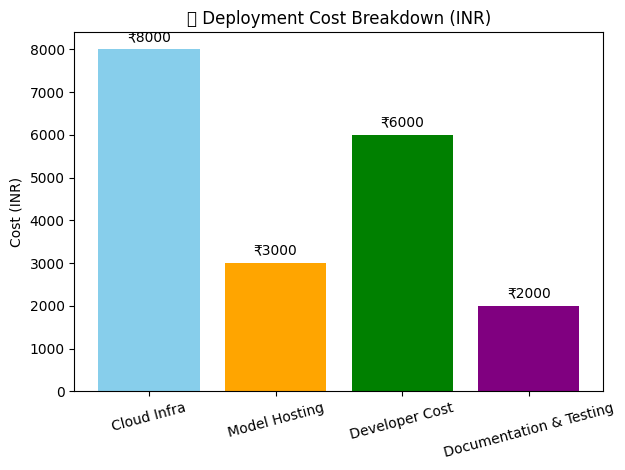

In [ ]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# ----------------- COST BREAKDOWN -----------------
components = ["Cloud Infra", "Model Hosting", "Developer Cost", "Documentation & Testing"]
costs = [8000, 3000, 6000, 2000]

fig, ax = plt.subplots()
bars = ax.bar(components, costs, color=['skyblue', 'orange', 'green', 'purple'])
ax.set_title("💸 Deployment Cost Breakdown (INR)")
ax.set_ylabel("Cost (INR)")
for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 200, f'₹{bar.get_height()}', ha='center')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


In [ ]:

# ----------------- REVENUE STREAMS -----------------
labels = ['B2B Licensing', 'Tier-2 Clients', 'Student Premium', 'API Access']
values = [60000, 45000, 49500, 20000]

fig2 = go.Figure(data=[go.Pie(labels=labels, values=values, hole=0.3)])
fig2.update_layout(title_text="💰 Monthly Revenue Distribution")
fig2.show()




<ipython-input-6-10f58f5f6fa3>:12: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.



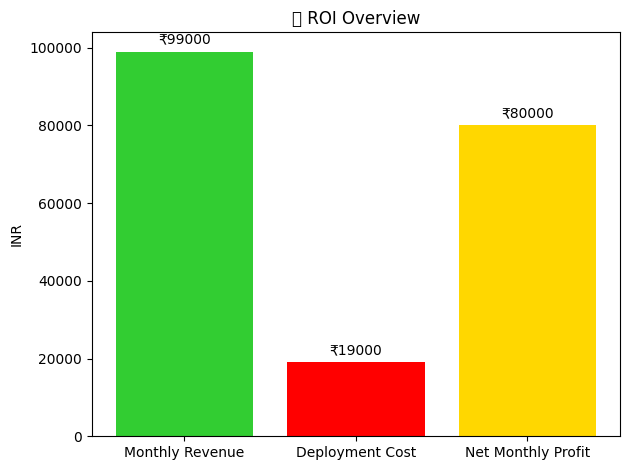

In [ ]:
# ----------------- ROI OVERVIEW -----------------
roi_labels = ['Monthly Revenue', 'Deployment Cost', 'Net Monthly Profit']
roi_values = [99000, 19000, 80000]
roi_colors = ['limegreen', 'red', 'gold']

fig3, ax3 = plt.subplots()
bars = ax3.bar(roi_labels, roi_values, color=roi_colors)
ax3.set_title("📈 ROI Overview")
ax3.set_ylabel("INR")
for bar in bars:
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2000, f'₹{bar.get_height()}', ha='center')
plt.tight_layout()
plt.show()